In [1]:
import numpy as np
from tools import adap_whitening_2, load, estimate_derivative
import pickle
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cycler import cycler

In [2]:
from matplotlib import font_manager as fm, rcParams

path = r"/home/p308270/.local/share/fonts/Helvetica.ttf"  # or .otf
fm.fontManager.addfont(path)
rcParams["font.family"] = fm.FontProperties(fname=path).get_name()


palette = ['#284bd5', '#c23232', '#269f30', '#1d1d1d']

plt.rcParams['axes.prop_cycle'] = cycler(color=palette)

In [3]:
def split(sensor_data, sequence, times_sec, sequence_sec, idx_split=450):

    labels = np.zeros_like(times_sec)
    for i, t in enumerate(sequence_sec[:idx_split]):
        try:
            flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
        except IndexError:
            flag = (times_sec > sequence_sec[i])
        labels[flag] = int(sequence[i][1])

    idx_last_flag = np.where(labels != 0)[0][-1]

    return sensor_data[:idx_last_flag], sequence[:idx_split], times_sec[:idx_last_flag], sequence_sec[:idx_split], \
           sensor_data[idx_last_flag:], sequence[idx_split:], times_sec[idx_last_flag:], sequence_sec[idx_split:]

def get_samples(sensor_data, sequence, times_sec, sequence_sec,
                idx_split_0=0, idx_split=450, t_training_delay=0.):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    count = 0

    for i, t in enumerate(sequence_sec):
        try:
            flags = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
        except IndexError:
            flags = (times_sec > sequence_sec[i] + t_training_delay)
        sample = sensor_data[flags][:18]
        t_sample = times_sec[flags]

        if i==387:   # Remove bad samples
            continue

        if idx_split_0 <= count < idx_split:
            X_train.append(sample.flatten())
            Y_train.append(sequence[i][1]-1)
            count += 1
        else:
            X_test.append(sample.flatten())
            Y_test.append(sequence[i][1]-1)


    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train, Y_train, X_test, Y_test

def plot_pca(X_train, Y_train, X_test, Y_test):
    pca = PCA(n_components=2)
    pca.fit(X_train)

    fig = plt.figure(figsize=(10, 5))
    g = fig.add_gridspec(1, 2)

    def format_ticks(ax):
        # Reset spines to normal positions
        ax.spines['left'].set_position(('outward', 0))
        ax.spines['bottom'].set_position(('outward', 0))
        ax.spines[['right', 'top']].set_visible(False)

        # Remove tick labels if you still want them hidden
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis="both", which="both", length=0)  # optional: hide tick marks

        # Axis labels positioned further out
        ax.set_xlabel("PC1", loc="right")   # push down/right
        ax.set_ylabel("PC2", loc="top")     # push left/top


    # Training set
    ax = fig.add_subplot(g[0, 0])
    sc_train = ax.scatter(
        pca.transform(X_train)[:, 0],
        pca.transform(X_train)[:, 1],
        c=Y_train
    )
    ax.set_title("Train", loc='right')
    format_ticks(ax)

    # Test set
    ax = fig.add_subplot(g[0, 1])
    sc_test = ax.scatter(
        pca.transform(X_test)[:, 0],
        pca.transform(X_test)[:, 1],
        c=Y_test
    )
    ax.set_title("Test", loc='right')
    format_ticks(ax)

    # Shared legend
    unique_labels = np.unique(np.concatenate([Y_train, Y_test]))
    handles = [plt.Line2D([], [], marker="o", linestyle="",
                          color=sc_train.cmap(sc_train.norm(l))) for l in unique_labels]
    fig.legend(handles, unique_labels, title="Classes", loc="upper right", frameon=False, bbox_to_anchor=(1, 0.6))

    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        52

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149



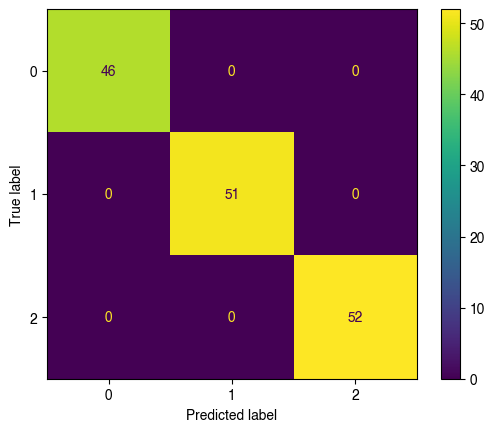

In [4]:
test_file = '1_600_20'

data, sequence, times_sec, sequence_sec = load(test_file, reduced=True)
X_train, Y_train, X_test, Y_test = get_samples(data, sequence, times_sec, sequence_sec,
                                        idx_split=450)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
print(metrics.classification_report(Y_test, Y_pred))

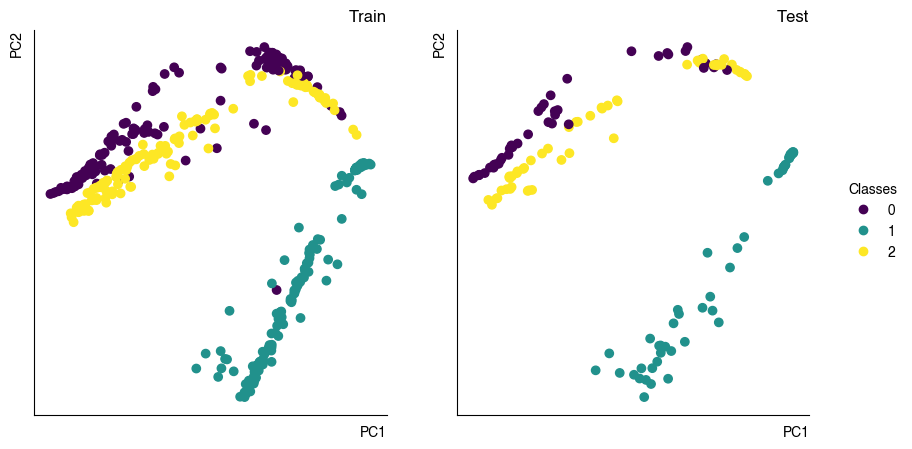

In [5]:
plot_pca(X_train, Y_train, X_test, Y_test)

--- n_samples=3 ---
              precision    recall  f1-score   support

           0       0.53      0.61      0.57        46
           1       0.68      0.96      0.80        51
           2       0.50      0.23      0.32        52

    accuracy                           0.60       149
   macro avg       0.57      0.60      0.56       149
weighted avg       0.57      0.60      0.56       149

--- n_samples=9 ---
              precision    recall  f1-score   support

           0       0.56      0.61      0.58        46
           1       1.00      1.00      1.00        51
           2       0.62      0.58      0.60        52

    accuracy                           0.73       149
   macro avg       0.73      0.73      0.73       149
weighted avg       0.73      0.73      0.73       149

--- n_samples=15 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       1.00      0.75      0.85        51
           2  

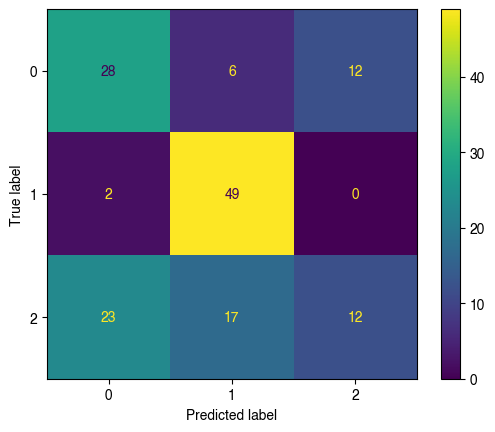

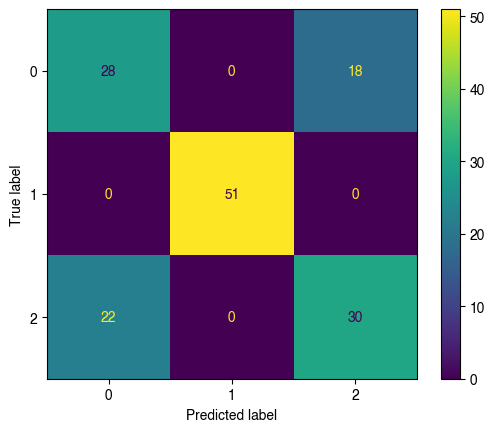

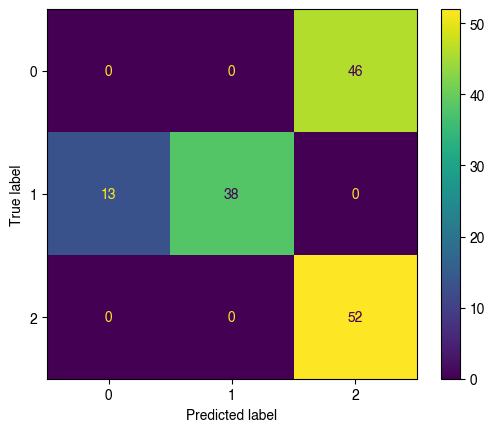

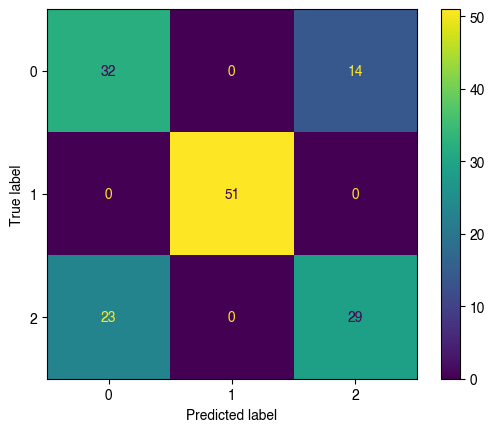

In [6]:
n_samples_list = [3, 9, 15, 30]

for n_samples in n_samples_list:
    data, sequence, times_sec, sequence_sec = load(f'1_{n_samples}_20', reduced=True)
    X_train, Y_train, _, _ = get_samples(data, sequence, times_sec, sequence_sec,
                                            idx_split=450)
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
    print(f'--- n_samples={n_samples} ---')
    print(metrics.classification_report(Y_test, Y_pred))

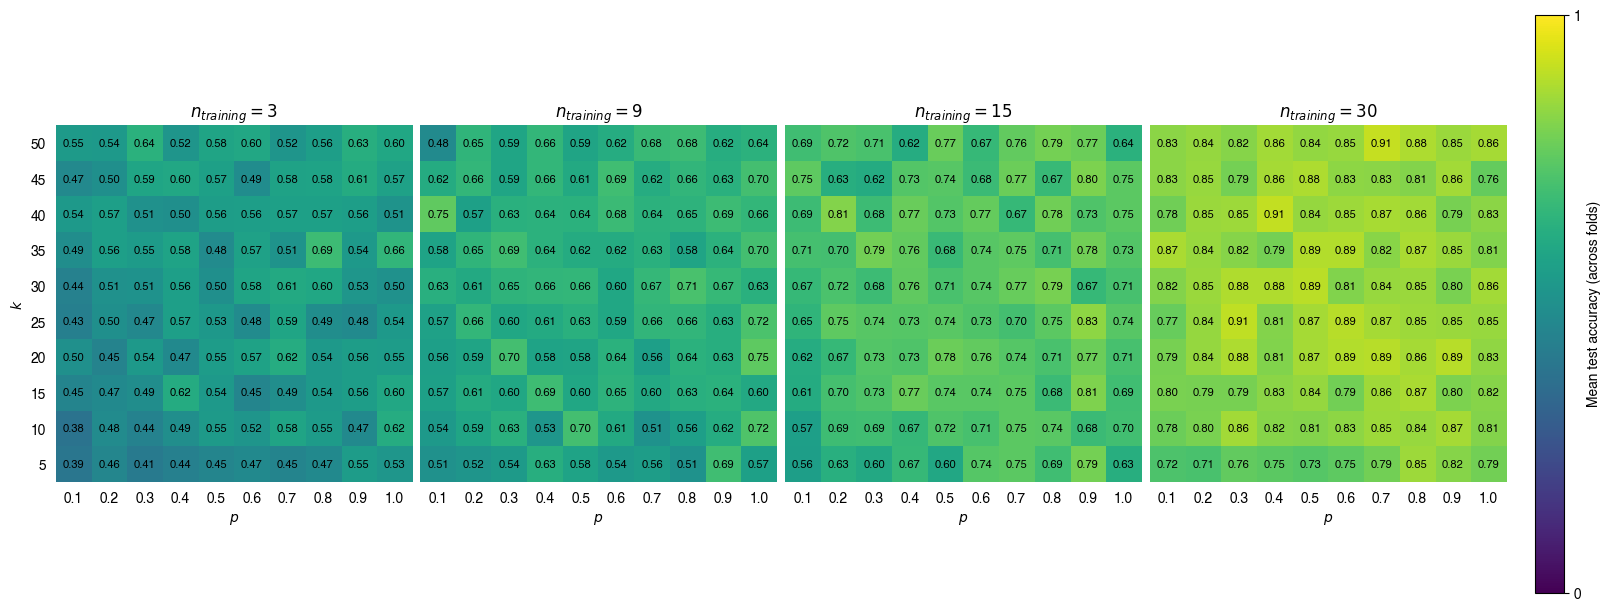

In [8]:
# Given grids
n_samples_list = [3, 9, 15, 30]
grid_k = np.arange(5, 55, 5)         # k on y-axis
grid_p = np.arange(0.1, 1.1, 0.1)    # p on x-axis
grid_n_fold = 5

# Create a 1x4 subplot grid (one column per n_samples)
fig, axes = plt.subplots(1, len(n_samples_list), figsize=(4*len(n_samples_list), 6),
                         constrained_layout=True)

# Ensure axes is iterable even if there's only one subplot
if len(n_samples_list) == 1:
    axes = np.array([axes])

all_ims = []

for col, n_samples in enumerate(n_samples_list):
    ax = axes[col]

    # Load data for this n_samples
    with open(f'data/gridsearch_{n_samples}.pkl', 'rb') as f:
        data = pickle.load(f)

    params = data['params']   # expected to include at least: 'k', 'p', and (optionally) 'fold'
    results = data['results'] # expected to include 'test_acc'

    # Build heatmap: rows = k, cols = p
    heat = np.full((len(grid_k), len(grid_p)), np.nan)

    # Vectorize for speed/readability
    k_all = params['k']
    p_all = params['p']
    test_all = results['test_acc']

    # If folds are explicit (e.g., params has 'fold'), averaging over flags handles it naturally
    # by selecting all rows with same (k, p) across folds.
    for i, k in enumerate(grid_k):
        for j, p in enumerate(grid_p):
            flags = (k_all == k) & np.isclose(p_all, p)
            # Average across folds for this (k, p)
            if np.any(flags):
                heat[i, j] = np.mean(test_all[flags])

    im = ax.imshow(
        heat,
        cmap='viridis',
        aspect='equal',
        origin='lower',
        vmin=0, vmax=1
    )
    all_ims.append(im)

    # Ticks & labels
    ax.set_xticks(np.arange(len(grid_p)))
    ax.set_yticks(np.arange(len(grid_k)))
    ax.set_xticklabels([f"{v:.1f}" for v in grid_p], rotation=0)
    if col == 0:
        ax.set_yticklabels([str(v) for v in grid_k])
    else:
        ax.set_yticklabels([])

    ax.set_xlabel('$p$')
    if col == 0:
        ax.set_ylabel('$k$')

    # Title for each subplot
    ax.set_title(f'$n_{{training}}={n_samples}$')

    # Neat look
    ax.tick_params(left=False, bottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate cells with values (optional: comment out if too dense)
    for (i, j), val in np.ndenumerate(heat):
        if np.isfinite(val):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8)

# One shared colorbar
cbar = fig.colorbar(all_ims[0], ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
cbar.set_ticks([0, 1])
cbar.set_label('Mean test accuracy (across folds)')

# plt.savefig('figs/gridsearch_singlerow.png', dpi=500)
# plt.savefig('figs/gridsearch_singlerow.pdf', dpi=500)
plt.show()


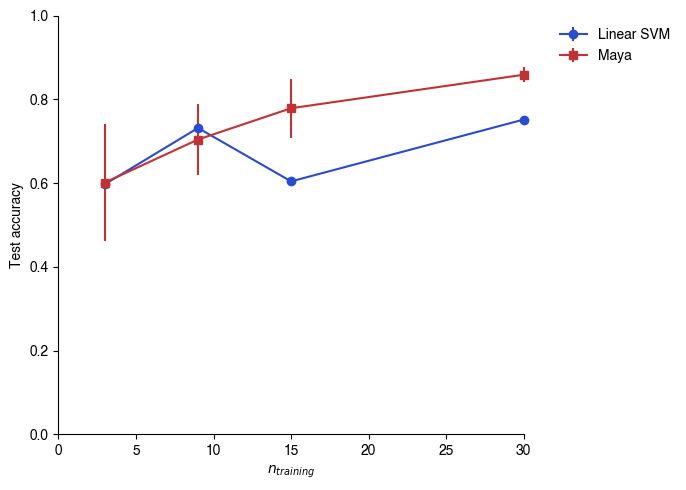

In [9]:
n_samples_list = [3, 9, 15, 30]
test_file = '1_600_20'

data, sequence, times_sec, sequence_sec = load(test_file, reduced=True)
_, _, X_test, Y_test = get_samples(data, sequence, times_sec, sequence_sec,
                                        idx_split=450)

svm_means, svm_stds = [], []
grid_means, grid_stds = [], []

for n_samples in n_samples_list:
    # --- Linear SVM ---
    data, sequence, times_sec, sequence_sec = load(f'1_{n_samples}_20', reduced=True)
    X_train, Y_train, _, _ = get_samples(
        data, sequence, times_sec, sequence_sec, idx_split=450
    )

    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)
    acc = metrics.accuracy_score(Y_test, Y_pred)

    svm_means.append(acc)
    svm_stds.append(0.0)  # no folds → no variance (unless you cross-val)

    # --- Gridsearch ---
    with open(f'data/gridsearch_1_{n_samples}_20.pkl', 'rb') as f:
        data = pickle.load(f)
    params = data['params']
    results = data['results']

    # best test acc per combination
    grid_accs = []
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)

                accs = results['test_acc'][flags]
                if len(accs) > 0:
                    grid_accs.append(np.mean(accs))

    best_acc = np.max(grid_accs)
    grid_means.append(best_acc)

    # get std of the best setting across folds
    best_flags = None
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs = results['test_acc'][flags]
                if len(accs) > 0 and np.mean(accs) == best_acc:
                    best_flags = flags
                    break
            if best_flags is not None:
                break
        if best_flags is not None:
            break

    grid_stds.append(np.std(results['test_acc'][best_flags]))

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.errorbar(n_samples_list, svm_means, yerr=svm_stds, fmt='-o', label='Linear SVM', clip_on=False)
plt.errorbar(n_samples_list, grid_means, yerr=grid_stds, fmt='-s', label='Maya', clip_on=False)

plt.xlabel('$n_{training}$')
plt.ylabel('Test accuracy')
plt.xlim(0, 30)
plt.ylim(0, 1)

# Remove grid
plt.grid(False)

# Hide top & right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend outside, top-right
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), frameon=False)

plt.tight_layout()
plt.savefig('figs/svm_vs_gridsearch.png', dpi=500, bbox_inches='tight')
plt.savefig('figs/svm_vs_gridsearch.pdf', dpi=500, bbox_inches='tight')
plt.show()



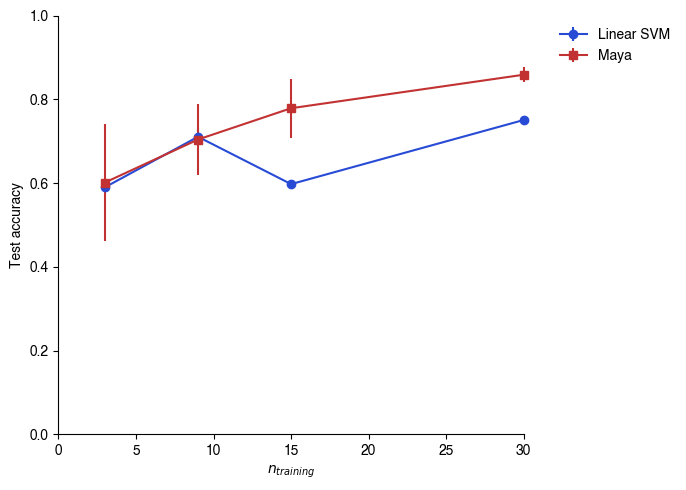

In [10]:
n_samples_list = [3, 9, 15, 30]
test_file = '1_600_20'

# Load the big test dataset once
data, sequence, times_sec, sequence_sec = load(test_file, reduced=True)

svm_means, svm_stds = [], []
grid_means, grid_stds = [], []

for n_samples in n_samples_list:
    # --- Linear SVM ---
    svm_accs = []
    for test_fold in range(2):
        # Build test set for this fold
        _, _, X_test, Y_test = get_samples(
            data, sequence, times_sec, sequence_sec,
            idx_split_0=150 * test_fold,
            idx_split=450 + 150 * test_fold
        )

        # Load training set for this n_samples
        train_data, train_seq, train_times, train_seq_times = load(f'1_{n_samples}_20', reduced=True)
        X_train, Y_train, _, _ = get_samples(
            train_data, train_seq, train_times, train_seq_times,
            idx_split=450
        )

        clf = svm.SVC(kernel='linear')
        clf.fit(X_train, Y_train)

        Y_pred = clf.predict(X_test)
        acc = metrics.accuracy_score(Y_test, Y_pred)
        svm_accs.append(acc)

    svm_means.append(np.mean(svm_accs))
    svm_stds.append(np.std(svm_accs))

    # --- Gridsearch (unchanged) ---
    with open(f'data/gridsearch_1_{n_samples}_20.pkl', 'rb') as f:
        data_gs = pickle.load(f)
    params = data_gs['params']
    results = data_gs['results']

    # best test acc per combination
    grid_accs = []
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)

                accs = results['test_acc'][flags]
                if len(accs) > 0:
                    grid_accs.append(np.mean(accs))

    best_acc = np.max(grid_accs)
    grid_means.append(best_acc)

    # get std of the best setting across folds
    best_flags = None
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs = results['test_acc'][flags]
                if len(accs) > 0 and np.mean(accs) == best_acc:
                    best_flags = flags
                    break
            if best_flags is not None:
                break
        if best_flags is not None:
            break

    grid_stds.append(np.std(results['test_acc'][best_flags]))

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.errorbar(n_samples_list, svm_means, yerr=svm_stds, fmt='-o', label='Linear SVM', clip_on=False)
plt.errorbar(n_samples_list, grid_means, yerr=grid_stds, fmt='-s', label='Maya', clip_on=False)

plt.xlabel('$n_{training}$')
plt.ylabel('Test accuracy')
plt.xlim(0, 30)
plt.ylim(0, 1)

# Remove grid
plt.grid(False)

# Hide top & right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend outside, top-right
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), frameon=False)

plt.tight_layout()
plt.savefig('figs/svmlinear_vs_maya.png', dpi=500, bbox_inches='tight')
plt.savefig('figs/svmlinear_vs_maya.pdf', dpi=500, bbox_inches='tight')
plt.show()

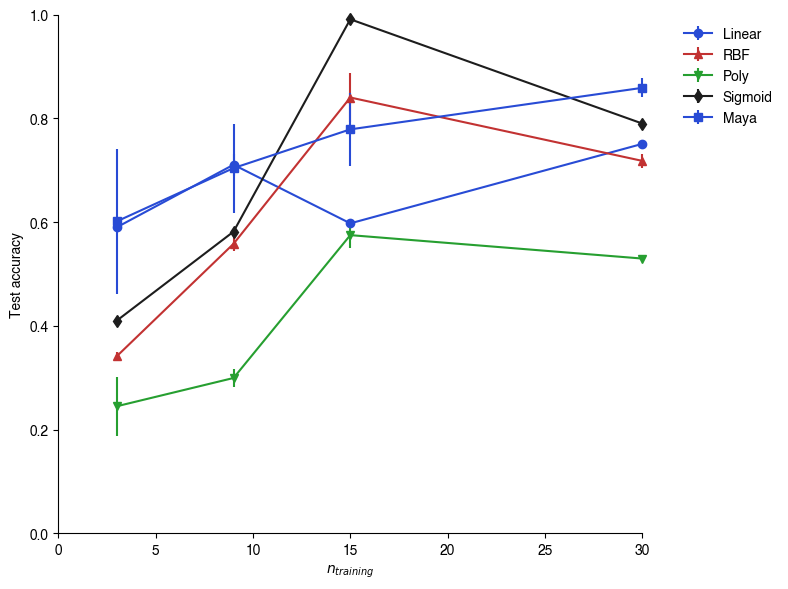

In [11]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform

n_samples_list = [3, 9, 15, 30]
test_file = '1_600_20'

# Load the big test dataset once
data, sequence, times_sec, sequence_sec = load(test_file, reduced=True)

# Store results
acc_means = {"linear": [], "rbf": [], "poly": [], "sigmoid": []}
acc_stds  = {"linear": [], "rbf": [], "poly": [], "sigmoid": []}
grid_means, grid_stds = [], []

for n_samples in n_samples_list:
    accs = {k: [] for k in acc_means.keys()}

    for test_fold in range(2):
        # Build test set
        _, _, X_test, Y_test = get_samples(
            data, sequence, times_sec, sequence_sec,
            idx_split_0=150 * test_fold,
            idx_split=450 + 150 * test_fold
        )

        # Load training set
        train_data, train_seq, train_times, train_seq_times = load(f'1_{n_samples}_20', reduced=True)
        X_train, Y_train, _, _ = get_samples(
            train_data, train_seq, train_times, train_seq_times,
            idx_split=450
        )
        n_train = len(Y_train)

        # --- Linear kernel ---
        clf_lin = svm.SVC(kernel="linear")
        clf_lin.fit(X_train, Y_train)
        accs["linear"].append(metrics.accuracy_score(Y_test, clf_lin.predict(X_test)))

        # --- RBF kernel ---
        cv = KFold(n_splits=min(3, n_train), shuffle=True, random_state=42)
        param_dist_rbf = {
            "svc__C": loguniform(1e-2, 1e3),
            "svc__gamma": loguniform(1e-3, 1e1)
        }
        search_rbf = RandomizedSearchCV(
            make_pipeline(StandardScaler(), svm.SVC(kernel="rbf")),
            param_distributions=param_dist_rbf,
            n_iter=30,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1,
            random_state=42
        )
        search_rbf.fit(X_train, Y_train)
        accs["rbf"].append(metrics.accuracy_score(Y_test, search_rbf.best_estimator_.predict(X_test)))

        # --- Polynomial kernel ---
        param_dist_poly = {
            "svc__C": loguniform(1e-2, 1e3),
            "svc__degree": [2, 3, 4],
            "svc__gamma": loguniform(1e-3, 1e1)
        }
        search_poly = RandomizedSearchCV(
            make_pipeline(StandardScaler(), svm.SVC(kernel="poly")),
            param_distributions=param_dist_poly,
            n_iter=30,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1,
            random_state=42
        )
        search_poly.fit(X_train, Y_train)
        accs["poly"].append(metrics.accuracy_score(Y_test, search_poly.best_estimator_.predict(X_test)))

        # --- Sigmoid kernel ---
        param_dist_sig = {
            "svc__C": loguniform(1e-2, 1e3),
            "svc__gamma": loguniform(1e-3, 1e1)
        }
        search_sig = RandomizedSearchCV(
            make_pipeline(StandardScaler(), svm.SVC(kernel="sigmoid")),
            param_distributions=param_dist_sig,
            n_iter=30,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1,
            random_state=42
        )
        search_sig.fit(X_train, Y_train)
        accs["sigmoid"].append(metrics.accuracy_score(Y_test, search_sig.best_estimator_.predict(X_test)))

    # Save mean/std per kernel
    for k in acc_means.keys():
        acc_means[k].append(np.mean(accs[k]))
        acc_stds[k].append(np.std(accs[k]))

    # --- Gridsearch (unchanged) ---
    with open(f'data/gridsearch_1_{n_samples}_20.pkl', 'rb') as f:
        data_gs = pickle.load(f)
    params = data_gs['params']
    results = data_gs['results']

    # best test acc per combination
    grid_accs = []
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs_fold = results['test_acc'][flags]
                if len(accs_fold) > 0:
                    grid_accs.append(np.mean(accs_fold))
    best_acc = np.max(grid_accs)
    grid_means.append(best_acc)
    best_flags = None
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs_fold = results['test_acc'][flags]
                if len(accs_fold) > 0 and np.mean(accs_fold) == best_acc:
                    best_flags = flags
                    break
            if best_flags is not None:
                break
        if best_flags is not None:
            break
    grid_stds.append(np.std(results['test_acc'][best_flags]))

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.errorbar(n_samples_list, acc_means["linear"], yerr=acc_stds["linear"], fmt="-o", label="Linear", clip_on=False)
plt.errorbar(n_samples_list, acc_means["rbf"], yerr=acc_stds["rbf"], fmt="-^", label="RBF", clip_on=False)
plt.errorbar(n_samples_list, acc_means["poly"], yerr=acc_stds["poly"], fmt="-v", label="Poly", clip_on=False)
plt.errorbar(n_samples_list, acc_means["sigmoid"], yerr=acc_stds["sigmoid"], fmt="-d", label="Sigmoid", clip_on=False)
plt.errorbar(n_samples_list, grid_means, yerr=grid_stds, fmt="-s", label="Maya", clip_on=False)

plt.xlabel("$n_{training}$")
plt.ylabel("Test accuracy")
plt.xlim(0, 30)
plt.ylim(0, 1)

# Clean style
plt.grid(False)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.), frameon=False)

plt.tight_layout()
plt.savefig("figs/svm_kernels.png", dpi=500, bbox_inches="tight")
plt.savefig("figs/svm_kernels.pdf", dpi=500, bbox_inches="tight")
plt.show()

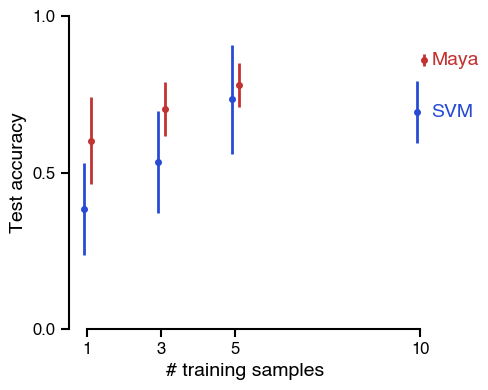

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform

n_samples_list = [3, 9, 15, 30]
test_file = '1_600_20'

# Load the big test dataset once (single test set)
data, sequence, times_sec, sequence_sec = load(test_file, reduced=True)
_, _, X_test, Y_test = get_samples(
    data, sequence, times_sec, sequence_sec,
    idx_split=450
)

# Store per-kernel results
acc_means = {"linear": [], "rbf": [], "poly": [], "sigmoid": []}
grid_means, grid_stds = [], []

for n_samples in n_samples_list:
    # Load training set
    train_data, train_seq, train_times, train_seq_times = load(f'1_{n_samples}_20', reduced=True)
    X_train, Y_train, _, _ = get_samples(
        train_data, train_seq, train_times, train_seq_times,
        idx_split=450
    )
    n_train = len(Y_train)

    # --- Linear kernel ---
    clf_lin = svm.SVC(kernel="linear")
    clf_lin.fit(X_train, Y_train)
    acc_means["linear"].append(metrics.accuracy_score(Y_test, clf_lin.predict(X_test)))

    # --- RBF kernel ---
    cv = KFold(n_splits=min(3, n_train), shuffle=True, random_state=42)
    param_dist_rbf = {
        "svc__C": loguniform(1e-2, 1e3),
        "svc__gamma": loguniform(1e-3, 1e1)
    }
    search_rbf = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="rbf")),
        param_distributions=param_dist_rbf,
        n_iter=30,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    search_rbf.fit(X_train, Y_train)
    acc_means["rbf"].append(metrics.accuracy_score(Y_test, search_rbf.best_estimator_.predict(X_test)))

    # --- Polynomial kernel ---
    param_dist_poly = {
        "svc__C": loguniform(1e-2, 1e3),
        "svc__degree": [2, 3, 4],
        "svc__gamma": loguniform(1e-3, 1e1)
    }
    search_poly = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="poly")),
        param_distributions=param_dist_poly,
        n_iter=30,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    search_poly.fit(X_train, Y_train)
    acc_means["poly"].append(metrics.accuracy_score(Y_test, search_poly.best_estimator_.predict(X_test)))

    # --- Sigmoid kernel ---
    param_dist_sig = {
        "svc__C": loguniform(1e-2, 1e3),
        "svc__gamma": loguniform(1e-3, 1e1)
    }
    search_sig = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="sigmoid")),
        param_distributions=param_dist_sig,
        n_iter=30,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42
    )
    search_sig.fit(X_train, Y_train)
    acc_means["sigmoid"].append(metrics.accuracy_score(Y_test, search_sig.best_estimator_.predict(X_test)))

    # --- Gridsearch (unchanged) ---
    with open(f'data/gridsearch_1_{n_samples}_20.pkl', 'rb') as f:
        data_gs = pickle.load(f)
    params = data_gs['params']
    results = data_gs['results']

    # best test acc per combination
    grid_accs = []
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs_fold = results['test_acc'][flags]
                if len(accs_fold) > 0:
                    grid_accs.append(np.mean(accs_fold))
    best_acc = np.max(grid_accs)
    grid_means.append(best_acc)
    best_flags = None
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs_fold = results['test_acc'][flags]
                if len(accs_fold) > 0 and np.mean(accs_fold) == best_acc:
                    best_flags = flags
                    break
            if best_flags is not None:
                break
        if best_flags is not None:
            break
    grid_stds.append(np.std(results['test_acc'][best_flags]))

# --- Average across kernels ---
avg_means, avg_stds = [], []
for i in range(len(n_samples_list)):
    kernel_means = [acc_means[k][i] for k in acc_means.keys()]
    avg_means.append(np.mean(kernel_means))
    avg_stds.append(np.std(kernel_means))

# --- Plot ---
# --- Rescale x-axis to samples per class ---
x_vals = np.array(n_samples_list) / 3.

plt.figure(figsize=(5, 4))

x = np.asarray(x_vals)
# pick a small offset relative to spacing (fallback if only one point)
dx = (np.diff(np.unique(x)).min() if x.size > 1 else 1.0) * 0.05

# SVM: shift left
plt.errorbar(
    x - dx, avg_means, yerr=avg_stds,
    linestyle='', linewidth=2, alpha=1.,
    fmt='o', markersize=4,
    capsize=0, clip_on=False
)

# Maya: shift right
plt.errorbar(
    x + dx, grid_means, yerr=grid_stds,
    linestyle='', linewidth=2, alpha=1.,
    fmt='o', markersize=4,
    capsize=0, clip_on=False
)


# Axis labels (same size as inline labels)
label_size = 14
plt.xlabel("# training samples", fontsize=label_size)
plt.ylabel("Test accuracy", fontsize=label_size)

# Axis limits + ticks (rescaled)
plt.xlim(0.5, max(x_vals))
plt.ylim(0, 1)
plt.xticks(x_vals, labels=[str(int(v)) for v in x_vals], fontsize=12)
plt.yticks([0, 0.5, 1], fontsize=12)

# No grid lines
plt.grid(False)

# Thicker axis lines + ticks
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis="both", width=1.5, length=6, labelsize=12)
ax.spines["bottom"].set_bounds(1, max(x_vals))

# Inline labels
plt.text(
    x_vals[-1] + 0.3, avg_means[-1],
    "SVM", color=palette[0],
    va="center", ha="left", fontsize=label_size
)
plt.text(
    x_vals[-1] + 0.3, grid_means[-1],
    "Maya", color=palette[1],
    va="center", ha="left", fontsize=label_size
)

plt.tight_layout()
plt.savefig("figs/svm_vs_maya.png", dpi=600, bbox_inches="tight")
plt.savefig("figs/svm_vs_maya.pdf", dpi=600, bbox_inches="tight")
plt.show()